# Appprentissage de Représentations Visuelles


In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import math

In [ ]:
def rgb2gray(rgb):
    return np.dot(rgb[..., :3], [0.2989, 0.5870, 0.1140])

def error(x, y):
    return ((x - y) ** 2).sum()

def seuillage(u, T):
    v = np.copy(u)
    return v * (v > T)

# Exemple
ex1d = [[i for i in range(1,9)] for j in range(8)]
ex2d = plt.imread('pictures/cameraman.pgm')

## 1. Implémentation l'algorithme Haar2D directe / inverse
* Avant l'implémentation de la trasformées multi-échelles sur deux dimensions, nous avons besoin d'avoir les transformées directes et inverses à une étape (avec une seul iteration). 

* Sinon on va avoir tous les détails de toutes les itérations, et ce que nous cherchons ici c'est de pouvroir diviser par deux chaque étapes de la transformé 2D.

In [ ]:
def haar_1d_directe_step(n, u, toPlot=False):
    u_f = np.array(u, dtype=float)
    v = np.copy(u_f)
    s = 2.0
    w = np.zeros(n)
    m = n // 2
    w[0:m]     = (v[0:2 * m - 1:2] + v[1:2 * m:2]) / s
    w[m:2 * m] = (v[0:2 * m - 1:2] - v[1:2 * m:2]) / s
    v[0:2 * m] = w[0:2 * m]
    if toPlot:
        print('haar',m,':', v)
    return w

def haar_1d_inverse_step(n, u):
    u_f = np.array(u, dtype=float)
    v = np.copy(u_f)
    s = 2.0
    w = np.zeros(n)
    m = n // 2
    w[0:2 * m - 1:2] = v[0:m] + v[m:2 * m] * s / 2
    w[1:2 * m:2] = v[0:m] - v[m:2 * m] * s / 2
    v[0:2 * m] = w[0:2 * m]
    return w

### Démonstration des transformées précédement implémentées 
Avant d'entamer l'implémentation de l'algorithme Haar 2D: on test sur un vecteur unidimensionnel les transformées de haar à une étape.

In [ ]:
print("vecteur initial : ", ex1d[0], "\n")

print("u8 : Test Haar 1D directe sur vecteur 1D (size : 8)")
# u8 : 4 pour approxim. et 4 pour détail
u8 = haar_1d_directe_step(8,ex1d[0])
print(u8, "\n")

print("Test Haar 1D inverse sur vecteur 1D (size : 8)")
# on reviens au vecteur initial
print(haar_1d_inverse_step(8,u8), "\n")

print("u4 : Test Haar 1D directe sur vecteur 1D (size : 4)")
# u4 : 2 pour approxim. et 2 pour détail
u4 = haar_1d_directe_step(4,u8[:4])
print(u4, "\n")

print("Test Haar 1D inverse sur vecteur 1D (size : 4)")
# ici on reviens à u8[:4] l'approxim du vecteur initial
v4 = haar_1d_inverse_step(4,u4)
print(v4, "\n")

print("u8 : on rajoute le détail de la première étape (size : 8)")
# on rajoute le détail de la première étape
w = np.concatenate((v4, u8[4:8]), axis=None)
print(w, "\n")

print("Test Haar 1D sur vecteur 1D inverse (size : 8)")
# on faisant l'inverse on doit retrouver le vecteur initial
print(haar_1d_inverse_step(8,w), "\n")

vecteur initial :  [1, 2, 3, 4, 5, 6, 7, 8] 

u8 : Test Haar 1D directe sur vecteur 1D (size : 8)
[ 1.5  3.5  5.5  7.5 -0.5 -0.5 -0.5 -0.5] 

Test Haar 1D inverse sur vecteur 1D (size : 8)
[1. 2. 3. 4. 5. 6. 7. 8.] 

u4 : Test Haar 1D directe sur vecteur 1D (size : 4)
[ 2.5  6.5 -1.  -1. ] 

Test Haar 1D inverse sur vecteur 1D (size : 4)
[1.5 3.5 5.5 7.5] 

u8 : on rajoute le détail de la première étape (size : 8)
[ 1.5  3.5  5.5  7.5 -0.5 -0.5 -0.5 -0.5] 

Test Haar 1D sur vecteur 1D inverse (size : 8)
[1. 2. 3. 4. 5. 6. 7. 8.] 



### Implémentaion de Haar2D
à chaque étape on fait une transformé sur l'approximation (uniquement) à partir des résultat trouvés dans l'iteration précédente.

In [ ]:
def haar2d_directe(n, u):
    v=np.copy(u)
    #print('shape de v', np.shape(v))
    w=np.zeros((n,n))
    m=n
    #transformation sur les lignes:
    while(1<m):
        for k in range(m):
            w[k,:m] = haar_1d_directe_step(m,v[k,:], toPlot=False)
        v=np.copy(w)
        #print('traitement des lignes à l\'étape',m,':\n',v)
        for k in range(m):
            w[:m,k] = haar_1d_directe_step(m,v[:,k], toPlot=False)
        v=np.copy(w)
        #print('traitement des colonnes à l\'étape',m,':\n',v)
        m=m//2
    return v

def haar2d_inverse(n, u):
    v=np.copy(u)
    #print('shape de v', np.shape(v))
    w=np.zeros((n,n))
    m = 2
    #transformation sur les lignes:
    while(m <= n):
        for k in range(m):
            w[:m,k] = haar_1d_inverse_step(m,v[:,k])
        v[:m,:m]=w[:m,:m]
        #print('on doit retrouver ici le traitement des lignes de l\'etape',m,':\n',v)
        for k in range(m):
            w[k,:m] = haar_1d_inverse_step(m,v[k,:])
        v[:m,:m]=w[:m,:m]
        #print('on doit retrouver ici le traitement des colonnes de l\'etape',m*2,':\n',v)
        m=m * 2
    return v

## Exercice 1 et 2 : Implémentation la transformée Quad2D directe / inverse:
même raisonnement que pour la transformée Haar2D

In [ ]:
def quadratic_1d_directe_step(n,u,show=False):
    u_f = np.array(u, dtype=float)
    v = np.copy(u_f)
    s = 2.0
    w = np.zeros(n)
    m = n
    m = m // 2 
    for j in range(0,m):
        w[j] = (v[2*j]+v[2*j+1]) / s
    for j in range (0,m):
        if j == 0:
            w[m+j] =  v[2*j] -  w[j]
        elif j == m - 1:
            w[m+j] =  v[2*j] -  w[j]
        else : 
            w[m+j] =  v[2*j] - (w[j]-1/8*(w[j-1]-w[j+1]))
    return w

def quadratic_1d_inverse_step(n,u,show=False):
    u_f = np.array(u, dtype=float)
    w = np.copy(u_f)
    v = np.zeros(n)
    m = n // 2
    for j in range (0,m):
        if j == 0:
            v[2*j] =  w[m+j] + w[j]
        elif j == (m - 1):
            v[2*j] =  w[m+j] + w[j]
        else : 
            v[2*j] =  w[m+j] + (w[j]-1/8*(w[j-1]-w[j+1]))
    for j in range(0,m):
        v[2*j+1] = 2*w[j]-v[2*j]
    return v

quadratic_1d_inverse_step(8,quadratic_1d_directe_step(8,ex1d[0]))

array([1., 2., 3., 4., 5., 6., 7., 8.])

### Tests des transformée quadratique à une étape

In [ ]:
print("vecteur initial : ", ex1d[0], "\n")

print("u8 : Test Haar 1D directe sur vecteur 1D (size : 8)")
# u8 : 4 pour approxim. et 4 pour détail
u8 = quadratic_1d_directe_step(8,ex1d[0])
print(u8, "\n")

print("Test Haar 1D inverse sur vecteur 1D (size : 8)")
# on reviens au vecteur initial
print(quadratic_1d_inverse_step(8,u8), "\n")

print("u4 : Test Haar 1D directe sur vecteur 1D (size : 4)")
# u4 : 2 pour approxim. et 2 pour détail
u4 = quadratic_1d_directe_step(4,u8[:4])
print(u4, "\n")

print("Test Haar 1D inverse sur vecteur 1D (size : 4)")
# ici on reviens à u8[:4] l'approxim du vecteur initial
v4 = quadratic_1d_inverse_step(4,u4)
print(v4, "\n")

print("u8 : on rajoute le détail de la première étape (size : 8)")
# on rajoute le détail de la première étape
w = np.concatenate((v4, u8[4:8]), axis=None)
print(w, "\n")

print("Test Haar 1D sur vecteur 1D inverse (size : 8)")
# on faisant l'inverse on doit retrouver le vecteur initial
print(quadratic_1d_inverse_step(8,w), "\n")

vecteur initial :  [1, 2, 3, 4, 5, 6, 7, 8] 

u8 : Test Haar 1D directe sur vecteur 1D (size : 8)
[ 1.5  3.5  5.5  7.5 -0.5 -1.  -1.  -0.5] 

Test Haar 1D inverse sur vecteur 1D (size : 8)
[1. 2. 3. 4. 5. 6. 7. 8.] 

u4 : Test Haar 1D directe sur vecteur 1D (size : 4)
[ 2.5  6.5 -1.  -1. ] 

Test Haar 1D inverse sur vecteur 1D (size : 4)
[1.5 3.5 5.5 7.5] 

u8 : on rajoute le détail de la première étape (size : 8)
[ 1.5  3.5  5.5  7.5 -0.5 -1.  -1.  -0.5] 

Test Haar 1D sur vecteur 1D inverse (size : 8)
[1. 2. 3. 4. 5. 6. 7. 8.] 



In [ ]:
def quad2d_directe(n, u):
    v=np.copy(u)
    #print('shape de v', np.shape(v))
    w=np.zeros((n,n))
    m=n
    #transformation sur les lignes:
    while(1<m):
        #print(m)
        for k in range(m):
            w[k,:m] = quadratic_1d_directe_step(m,v[k,:])
        v=np.copy(w)
        #print('traitement des lignes à l\'étape',m,':\n',v)
        for k in range(m):
            w[:m,k] = quadratic_1d_directe_step(m,v[:,k])
        v=np.copy(w)
        #print('traitement des colonnes à l\'étape',m,':\n',v)
        m=m//2
    return v

def quad2d_inverse(n, u):
    v=np.copy(u)
    #print('shape de v', np.shape(v))
    w=np.zeros((n,n))
    m = 2
    #transformation sur les lignes:
    while(m <= n):
        for k in range(m):
            w[:m,k] = quadratic_1d_inverse_step(m,v[:,k])
        v[:m,:m]=w[:m,:m]
        #print('on doit retrouver ici le traitement des lignes de l\'etape',m,':\n',v)
        for k in range(m):
            w[k,:m] = quadratic_1d_inverse_step(m,v[k,:])
        v[:m,:m]=w[:m,:m]
        #print('on doit retrouver ici le traitement des colonnes de l\'etape',m*2,':\n',v)
        m=m * 2
    return v

## 2. Propriété d'identité: Test sur une image

haar2D error :  0.0
quad2D error :  0.0


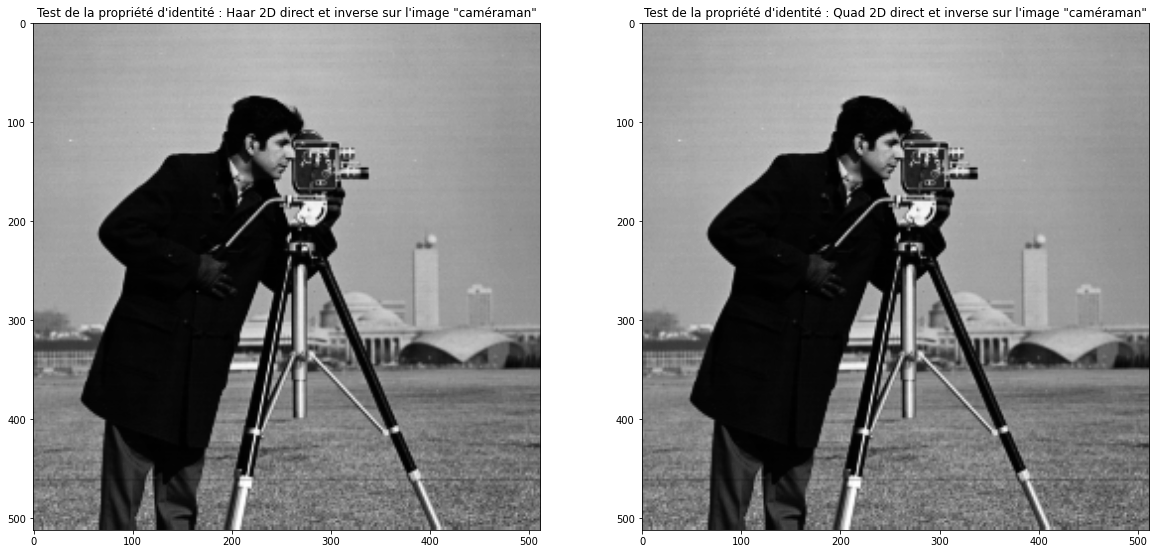

In [ ]:
img_haar = haar2d_inverse(512,haar2d_directe(512, ex2d))
img_quad = quad2d_inverse(512,quad2d_directe(512, ex2d))
print("haar2D error : ", error(img_haar, ex2d))
print("quad2D error : ", error(img_quad, ex2d))

plt.figure(figsize=(20,15))

plt.subplot(1,2,1)
plt.title("Test de la propriété d'identité : Haar 2D direct et inverse sur l'image \"caméraman\"")
plt.imshow(img_haar, cmap='gray')

plt.subplot(1,2,2)
plt.title("Test de la propriété d'identité : Quad 2D direct et inverse sur l'image \"caméraman\"")
plt.imshow(img_quad, cmap='gray')

plt.show()

### Autres tests:  Approximation /Détail Horizontal / Détail Vertical / Détail Diagonal
On en aura besoin pour les questions qui vont suivre

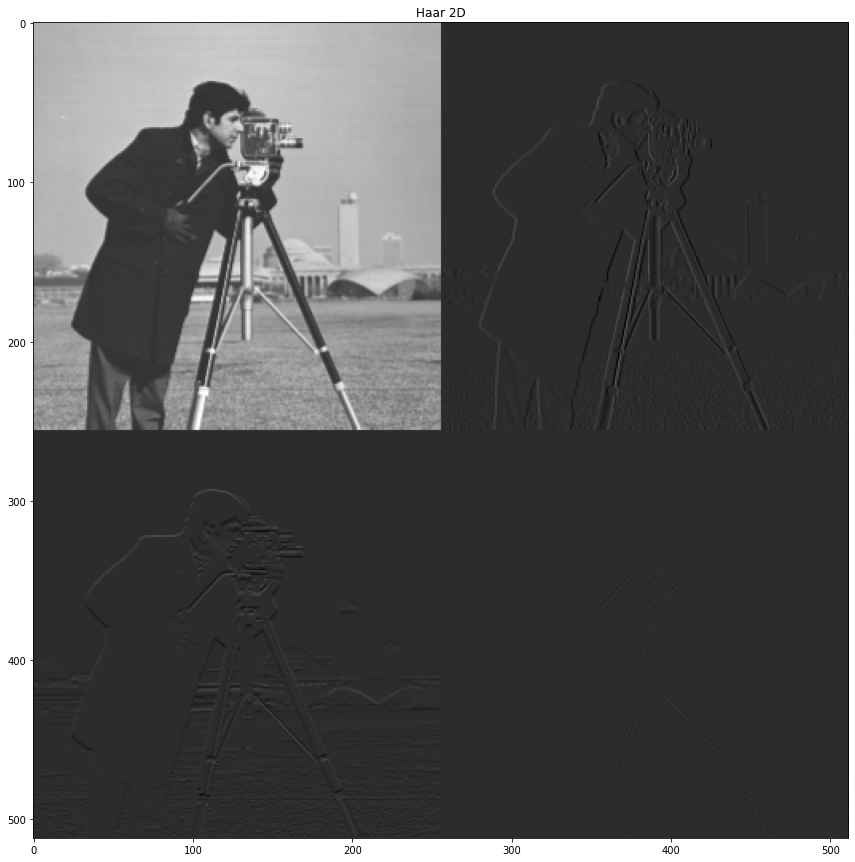

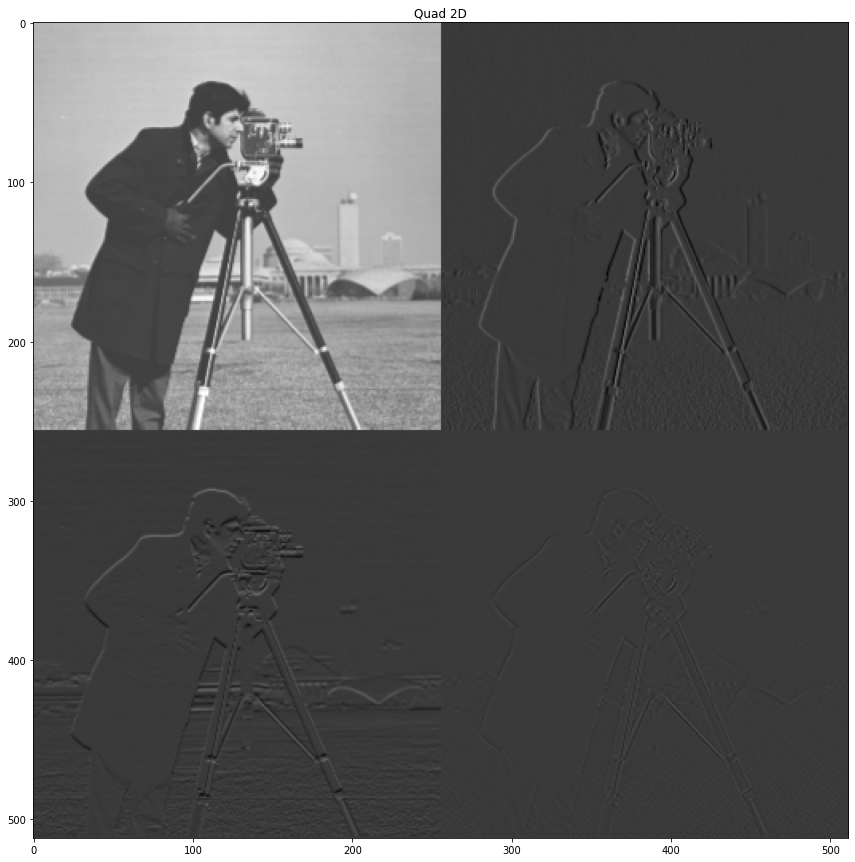

In [ ]:
img_haar = haar2d_inverse(256,haar2d_directe(512, ex2d))
img_quad = quad2d_inverse(256,quad2d_directe(512, ex2d))

plt.figure(figsize=(15,15))
plt.title('Haar 2D')
plt.imshow(img_haar, cmap='gray')
plt.show()

plt.figure(figsize=(15,15))
plt.title('Quad 2D')
plt.imshow(img_quad, cmap='gray')
plt.show()

## 3. Ajout d'un bruit gaussien

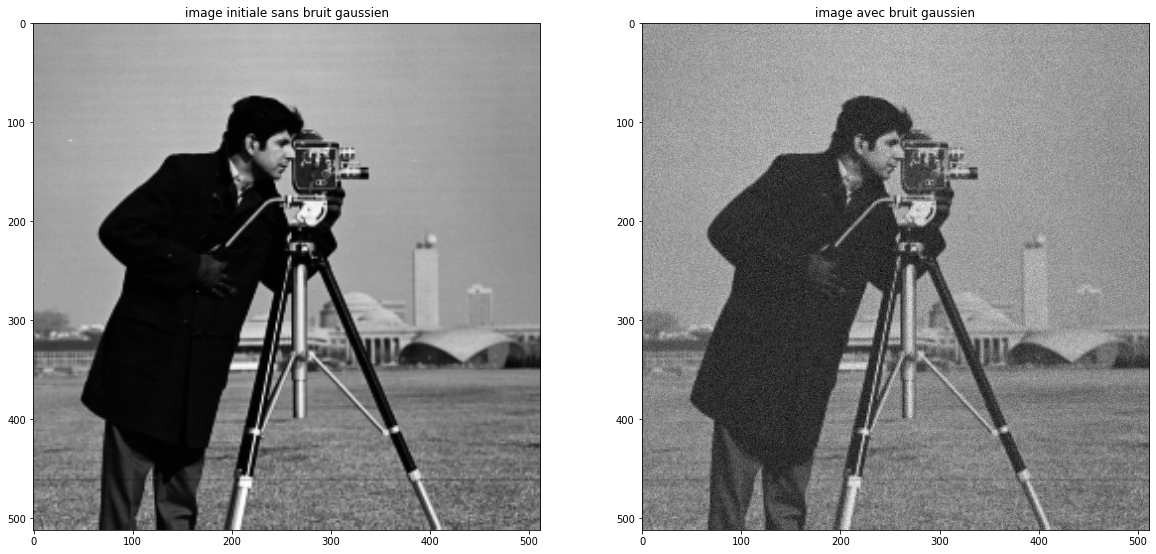

In [ ]:
noise = np.random.normal(loc=0, scale=15, size=512*512)
noise = noise.reshape(512,512)
ex2dn = ex2d + noise

plt.figure(figsize=(20,15))

plt.subplot(1,2,1)
plt.title("image initiale sans bruit gaussien")
plt.imshow(ex2d, cmap='gray')

plt.subplot(1,2,2)
plt.title("image avec bruit gaussien")
plt.imshow(ex2dn, cmap='gray')
plt.show()

0.028591116347912067 8.25921200982379 -78.29051268496085 118.85165655078114
0.06326010519471563 9.958076262799585 -94.54108457274857 118.85165655078114


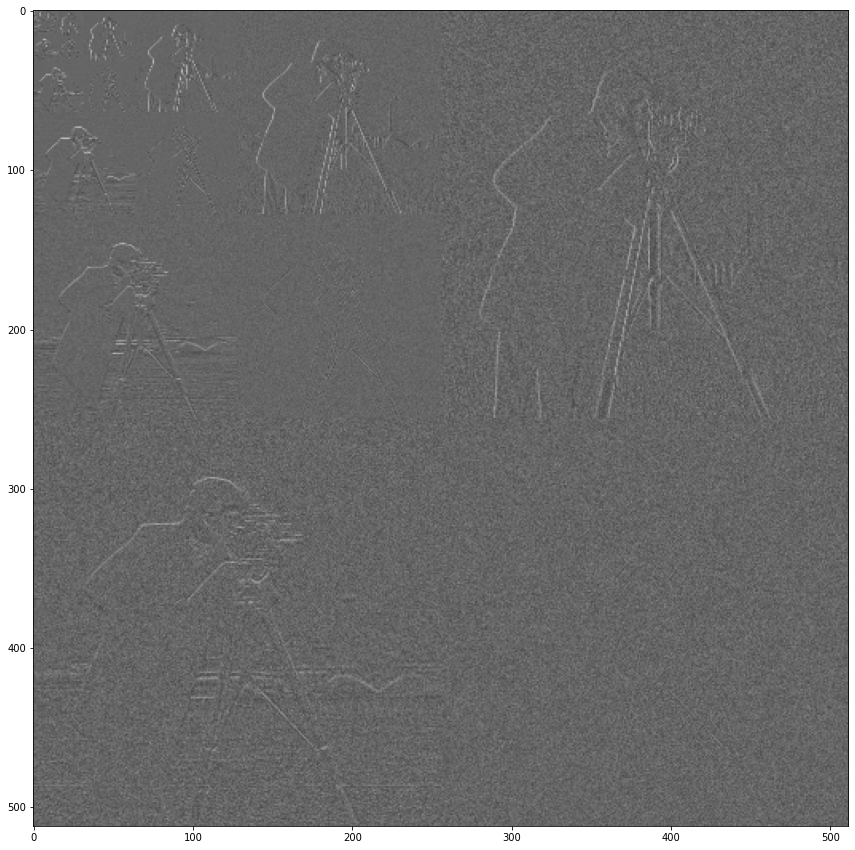

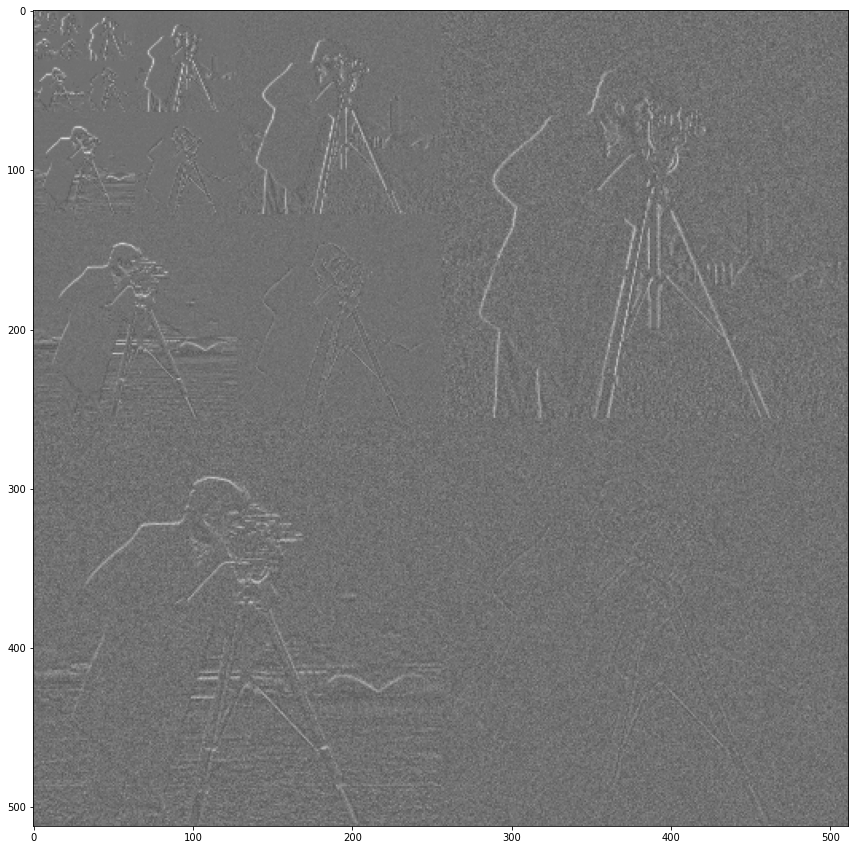

In [ ]:
s = -20
tr2d_haar = haar2d_directe(512, ex2dn)
tr2d_quad = quad2d_directe(512, ex2dn)

print(tr2d_haar.mean(), tr2d_haar.std(), tr2d_haar.min(), tr2d_haar.max())
print(tr2d_quad.mean(), tr2d_quad.std(), tr2d_quad.min(), tr2d_quad.max())

plt.figure(figsize=(20,15))
plt.imshow (seuillage(tr2d_haar, s), cmap='gray', vmin = tr2d_haar.min(), vmax = tr2d_haar.max())
plt.show()
plt.figure(figsize=(20,15))
plt.imshow (seuillage(tr2d_quad, s), cmap='gray', vmin = tr2d_quad.min(), vmax = tr2d_quad.max())
plt.show()

### Commentaires :

* On remarque que le bruit ajouté est plus localisé dans les zones homogènes de l'image (pas dans les contours)

## 3. Graphe de l'erreur en fonction du seuil et Qualité de la reconstruction
L'histograme nous donne la distribution des coéfficients des transformées multi-echelles utilisées.

On calcule l'erreur sur l'image en fonction du seuil, on rajoute ici aussi le nombre de coefficient gardé en fonction du seuil.

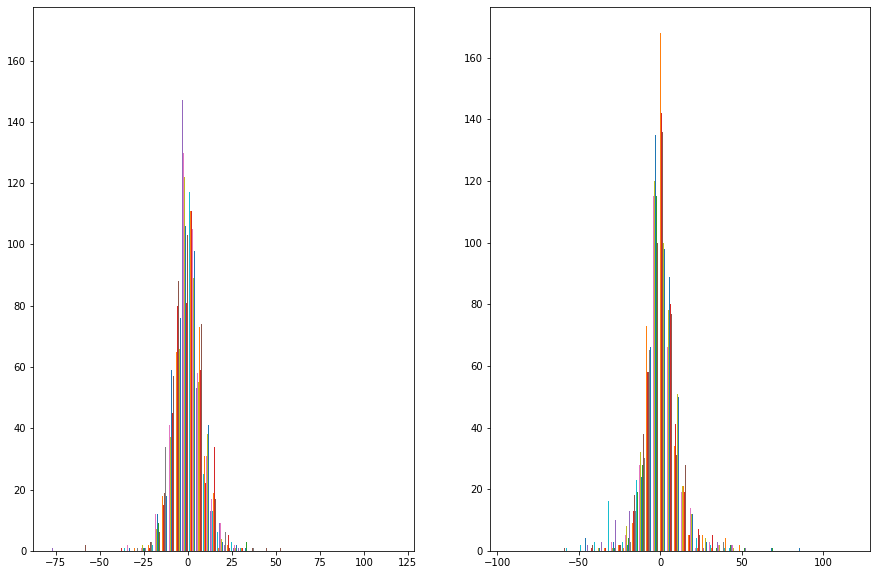

In [ ]:
u = ex2dn
v1   = haar2d_directe(512, u)
v2   = quad2d_directe(512, u)

plt.figure(figsize=(15,10))
plt.subplot(1,2,1)
plt.hist(v1, bins=50)
plt.subplot(1,2,2)
plt.hist(v2, bins=50)
plt.show()

__________________________________Exemple image cameraman__________________________________


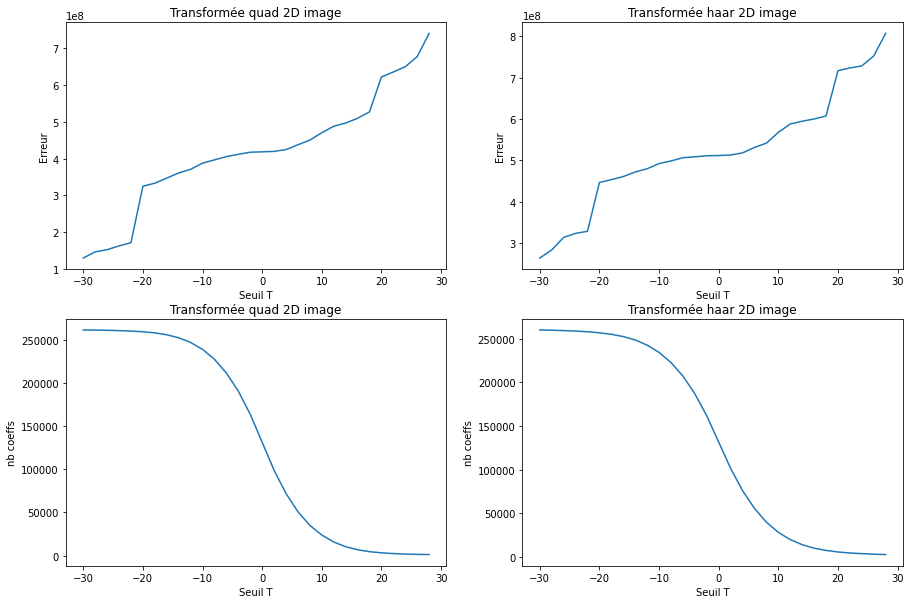

In [ ]:
plt.figure(figsize=(15,10))

print('__________________________________Exemple image cameraman__________________________________')    
erreurs1 = []
erreurs2 = []
ncoeffs1 = []
ncoeffs2 = []

seuils = range(-30,+30,2)
for j, T in enumerate(seuils):
    #print('seuil en cours : ', T)
    v1s   = seuillage(v1, T)
    res1 = haar2d_inverse(512,v1s)
    v2s   = seuillage(v2, T)
    res2 = quad2d_inverse(512,v2s)
    erreurs1.append(error(u, res1))
    erreurs2.append(error(u, res2))
    ncoeffs1.append(np.count_nonzero(v1s))
    ncoeffs2.append(np.count_nonzero(v2s))

plt.subplot(2,2,1)
plt.title(f'Transformée quad 2D image')
plt.xlabel('Seuil T')
plt.ylabel('Erreur')
plt.plot(seuils, erreurs1)
    
plt.subplot(2,2,2)
plt.title(f'Transformée haar 2D image')
plt.xlabel('Seuil T')
plt.ylabel('Erreur')
plt.plot(seuils, erreurs2)
    
plt.subplot(2,2,3)
plt.title(f'Transformée quad 2D image')
plt.xlabel('Seuil T')
plt.ylabel('nb coeffs')
plt.plot(seuils, ncoeffs1)    
    
plt.subplot(2,2,4)
plt.title(f'Transformée haar 2D image')
plt.xlabel('Seuil T')
plt.ylabel('nb coeffs')
plt.plot(seuils, ncoeffs2) 

plt.show()

### Qualité de la reconstruction sur l'image avec bruit gaussien : en fonction du seuil (donc par rapport aux coéfficients gardés)

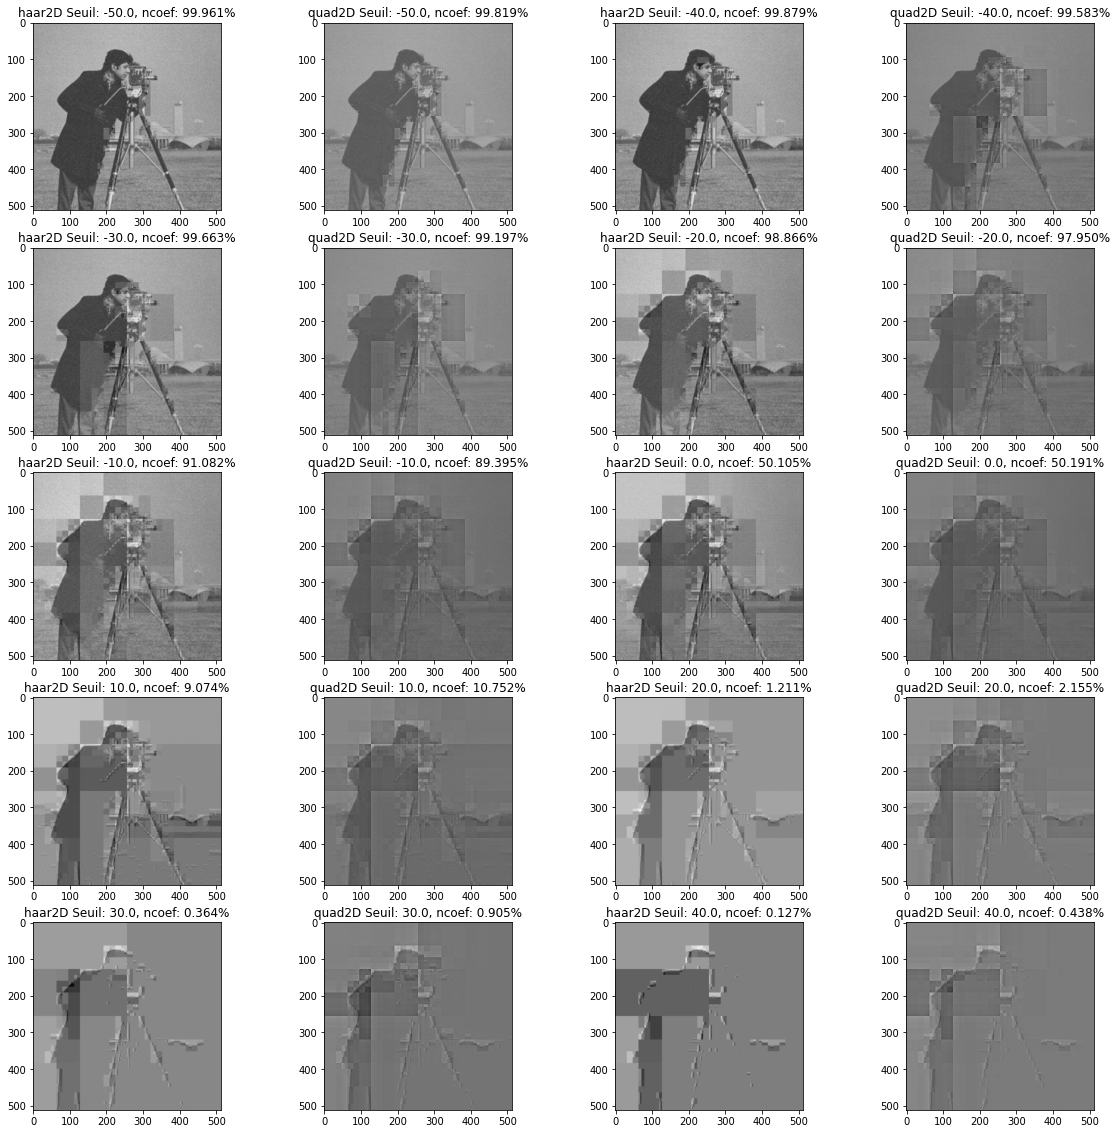

In [ ]:
plt.figure(figsize=(20,20))
v1   = haar2d_directe(512, ex2dn)
v2   = quad2d_directe(512, ex2dn)
seuils=[float(i) for i in np.arange(-50,50,10)]
for j, T in enumerate(seuils):
    v1s   = seuillage(v1, T)
    res1 = haar2d_inverse(512,v1s)
    plt.subplot(5,4,2*j+1)
    pcoef1 = "%.3f" % (np.count_nonzero(v1s)*100.0/(512*512))
    plt.title(f'haar2D Seuil: {T}, ncoef: {pcoef1}%')
    plt.imshow(res1, cmap='gray')
    v2s   = seuillage(v2, T)
    res2 = quad2d_inverse(512,v2s)
    plt.subplot(5,4,2*j+2)
    pcoef2 = "%.3f" % (np.count_nonzero(v2s)*100.0/(512*512))
    plt.title(f'quad2D Seuil: {T}, ncoef: {pcoef2}%')
    plt.imshow(res2, cmap='gray')
plt.show()

### Qualité de la reconstruction sur l'image sans bruit gaussien :

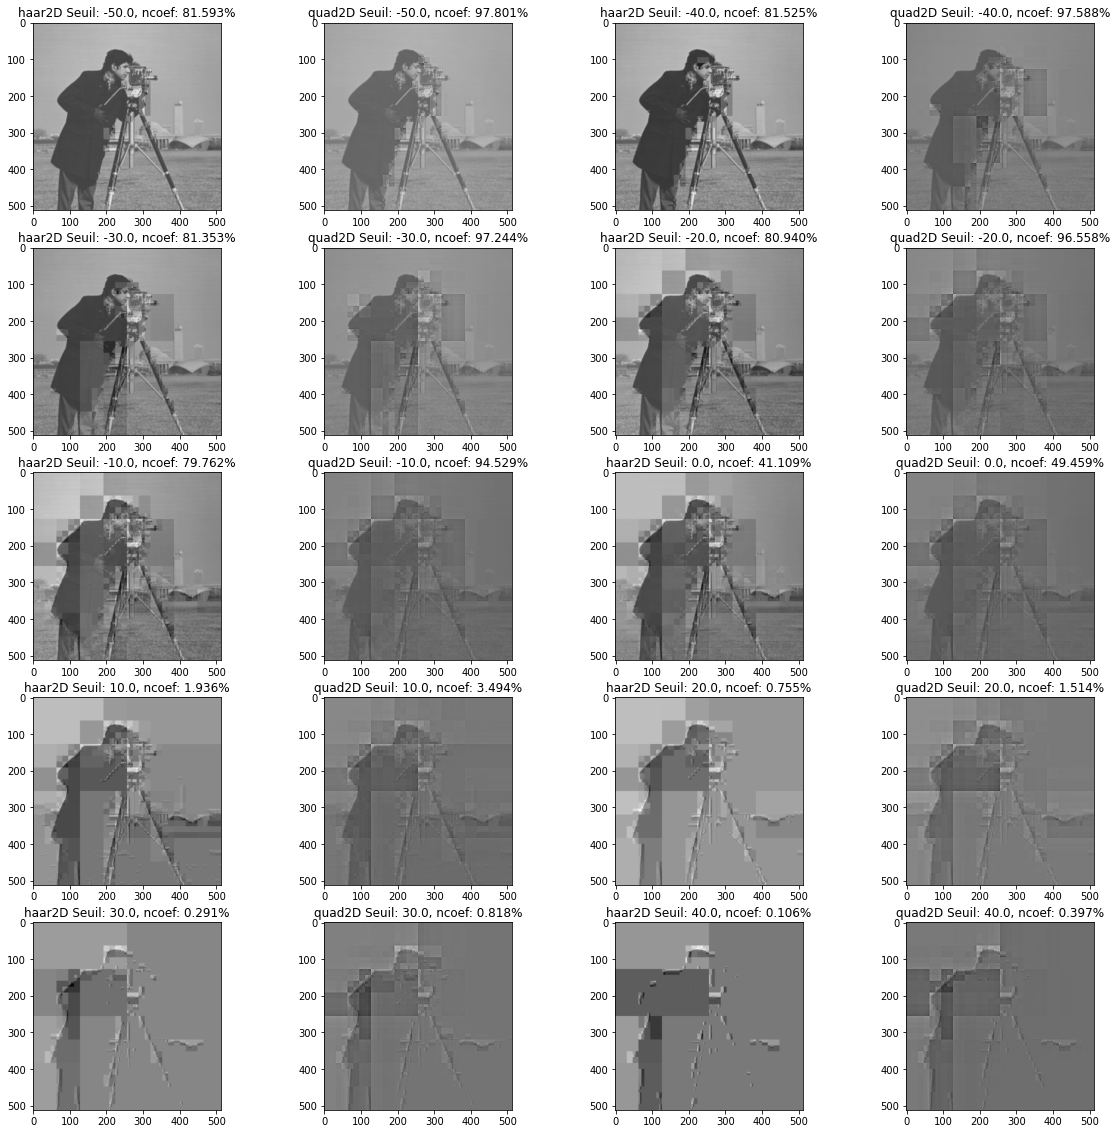

In [ ]:
plt.figure(figsize=(20,20))
v1   = haar2d_directe(512, ex2d)
v2   = quad2d_directe(512, ex2d)
seuils=[float(i) for i in np.arange(-50,50,10)]
for j, T in enumerate(seuils):
    v1s   = seuillage(v1, T)
    res1 = haar2d_inverse(512,v1s)
    plt.subplot(5,4,2*j+1)
    pcoef1 = "%.3f" % (np.count_nonzero(v1s)*100.0/(512*512))
    plt.title(f'haar2D Seuil: {T}, ncoef: {pcoef1}%')
    plt.imshow(res1, cmap='gray')
    v2s   = seuillage(v2, T)
    res2 = quad2d_inverse(512,v2s)
    plt.subplot(5,4,2*j+2)
    pcoef2 = "%.3f" % (np.count_nonzero(v2s)*100.0/(512*512))
    plt.title(f'quad2D Seuil: {T}, ncoef: {pcoef2}%')
    plt.imshow(res2, cmap='gray')
plt.show()

### Test avec un seuil s donné

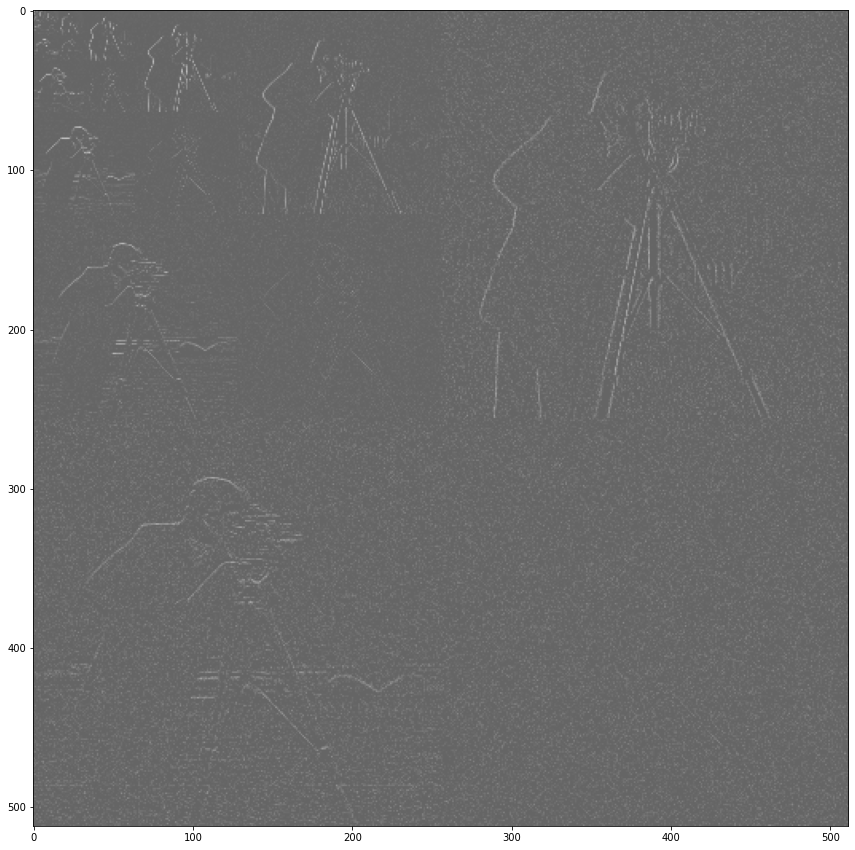

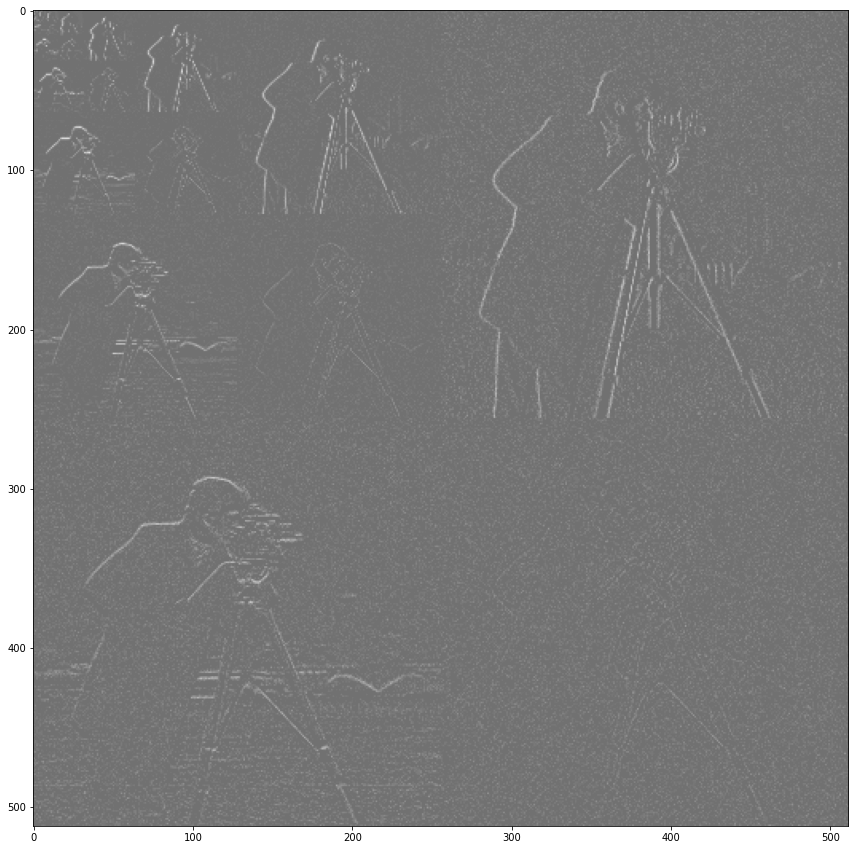

In [ ]:
s = 0
tr2d_haar = haar2d_directe(512, ex2dn)
tr2d_quad = quad2d_directe(512, ex2dn)

plt.figure(figsize=(20,15))
plt.imshow (seuillage(tr2d_haar, s), cmap='gray', vmin = tr2d_haar.min(), vmax = tr2d_haar.max())
plt.show()
plt.figure(figsize=(20,15))
plt.imshow (seuillage(tr2d_quad, s), cmap='gray', vmin = tr2d_quad.min(), vmax = tr2d_quad.max())
plt.show()

On remarque dans les images ci-dessous que : 
* plus le seuil augmente plus le bruit disparait au risque de faire disparaitre à son les informations de l'image initiale.